<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# kaiser window is adjustable
# we can optimmise the beta parameter to balance between sensitivity, main lobe width and contrast


In [5]:
# run this on top of all of Your notebooks -- it does all the dirty imports.
exec(open('initialize_jupyter_handybeam.py').read())
import strathclyde

current_dir is "C:\Users\JerzyDziewierz\Documents\git\handybeam-project\ul-handybeam-examples\EngD-course-root"
expecting handybeam module at "C:\Users\JerzyDziewierz\Documents\git\handybeam-project\handybeam-core-code"


C:\Users\JerzyDziewierz\Documents\git\handybeam-project\handybeam-core-code\handybeam\solver.py:12: UserWarning: solver.py is obsolete - use beamformer.py instead
  warnings.warn('solver.py is obsolete - use beamformer.py instead')


In [6]:
from IPython.core.debugger import set_trace


In [7]:
# make a shortcut function that runs the entire HandyBeam process and returns nicely formatted outputs

def array_using_kaiser(beta=1):
    focal_point=(0.0,30e-3,40e-3)
    focal_radius=np.sqrt(focal_point[0]**2+focal_point[1]**2+focal_point[2]**2)
    # array builder
    array_builder=strathclyde.LinearArray(
        radiation_frequency=500e3,
        sound_velocity=5600,
        sampling_density=11,
        passive_aperture=32e-3,
        element_pitch=3e-3,
        element_width=1e-3,
        element_count=16,
        focal_point=focal_point,
        amplitude_setting=1e4,
        window_coefficients=scipy.signal.windows.kaiser(16,beta=beta))
    # handybeam
    handybeam_world = array_builder.create_handybeam_world()
    
    # create a sampling line, semi-circle around the array, to sample the field there
    semicircle_sampler=handybeam_world.add_sampler(handybeam.samplers.arcYZ.arcYZ(world=handybeam_world,radius=focal_radius,points_per_wavelength=123))
    semicircle_sampler.propagate(print_performance_feedback=False)
    # analiser
    stats=strathclyde.analyse_semicircle_sampled_data(semicircle_sampler.sampler_angles,
                                                      semicircle_sampler.radius,
                                                      semicircle_sampler.pressure_field,
                                                      semicircle_sampler.distance_between_points)
    return array_builder,handybeam_world,semicircle_sampler,semicircle_sampler.sampler_angles,stats,handybeam_world

Main lobe:
 >> peak amplitude value: 1.007438063621521
 >> peak location : 0.647 radians = 37.04 degrees
 >> angular width (-3dB): 0.248 radians = 14.19 degrees
 >> linear width (-3dB): 12.384mm 
integrated main lobe power: 0.02055105587924882
Side lobes:
 >> peak side lobe value :0.2665855288505554
 >> integrated side lobe power: 0.003069590263537325
Contrast metric:
 >> integrated main lobe to side lobe ratio: 16.52 dB


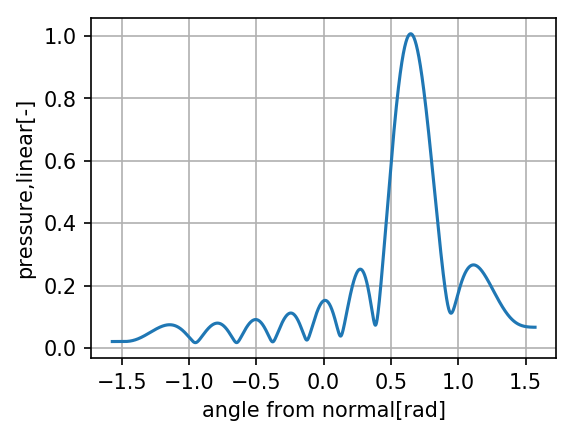

In [8]:

ab,hw,sc,sampler_angles,stats,handybeam_world = array_using_kaiser(0.01)
strathclyde.print_analysis(stats)
handybeam.visualise.plot_1D_pressure_vs_angle(hw,sampler_angles,np.abs(sc.pressure_field))

In [9]:
# run a parameter sweep: try beta in range of 0.1 to 10

kaiser_betas=np.linspace(0.1,6,50)
print(f'computing {kaiser_betas.shape[0]} cases')
# reserve buffers for interesting outputs, discard the rest
power_main_lobes=np.full(kaiser_betas.shape,np.nan)
contrast_mts_ratios=np.full(kaiser_betas.shape,np.nan)
beam_width_linears=np.full(kaiser_betas.shape,np.nan)

# run the calculations for all betas of interest
for idx,beta in enumerate(kaiser_betas):
    ab,hw,sc,sampler_angles,stats,handybeam_world = array_using_kaiser(beta)
    power_main_lobes[idx]=stats.power_main_lobe
    contrast_mts_ratios[idx]=stats.contrast_mts_ratio
    beam_width_linears[idx]=stats.beam_width_linear
    print('.',end='')
    
    

computing 50 cases
..................................................

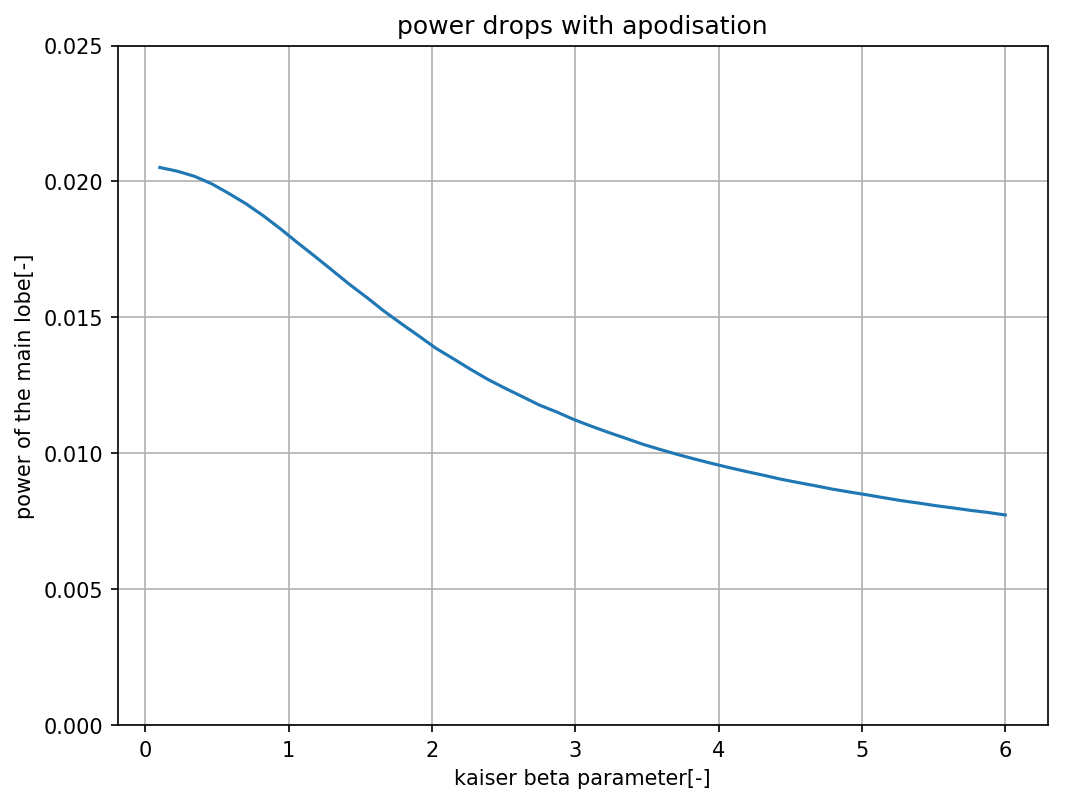

In [12]:
# plot the sensitivity (power_main_lobes)
plt.figure(figsize=(8,6),dpi=150)
plt.plot(kaiser_betas,power_main_lobes)
plt.xlabel('kaiser beta parameter[-]')
plt.ylabel('power of the main lobe[-]')
plt.title('power drops with apodisation')
plt.ylim(0,25e-3)
plt.grid(True)

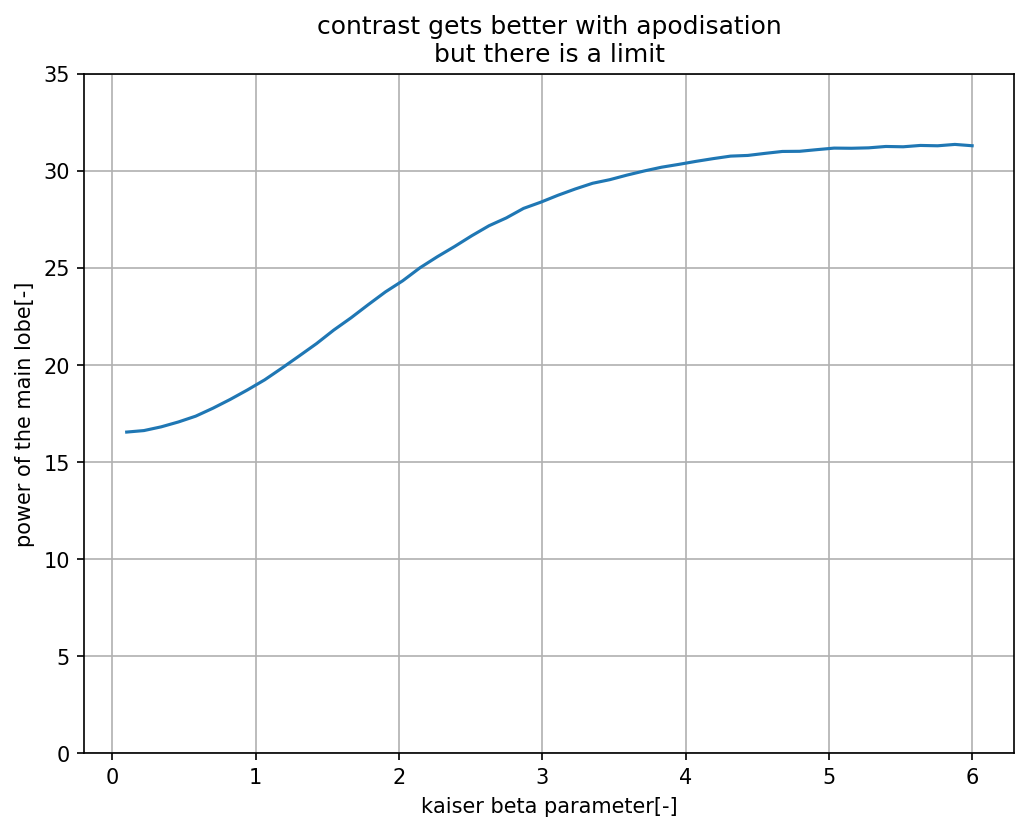

In [13]:
# plot the contrast measure
plt.figure(figsize=(8,6),dpi=150)
plt.plot(kaiser_betas,contrast_mts_ratios)

plt.xlabel('kaiser beta parameter[-]')
plt.ylabel('power of the main lobe[-]')
plt.title('contrast gets better with apodisation\nbut there is a limit')
plt.ylim(0,35)
plt.grid(True)

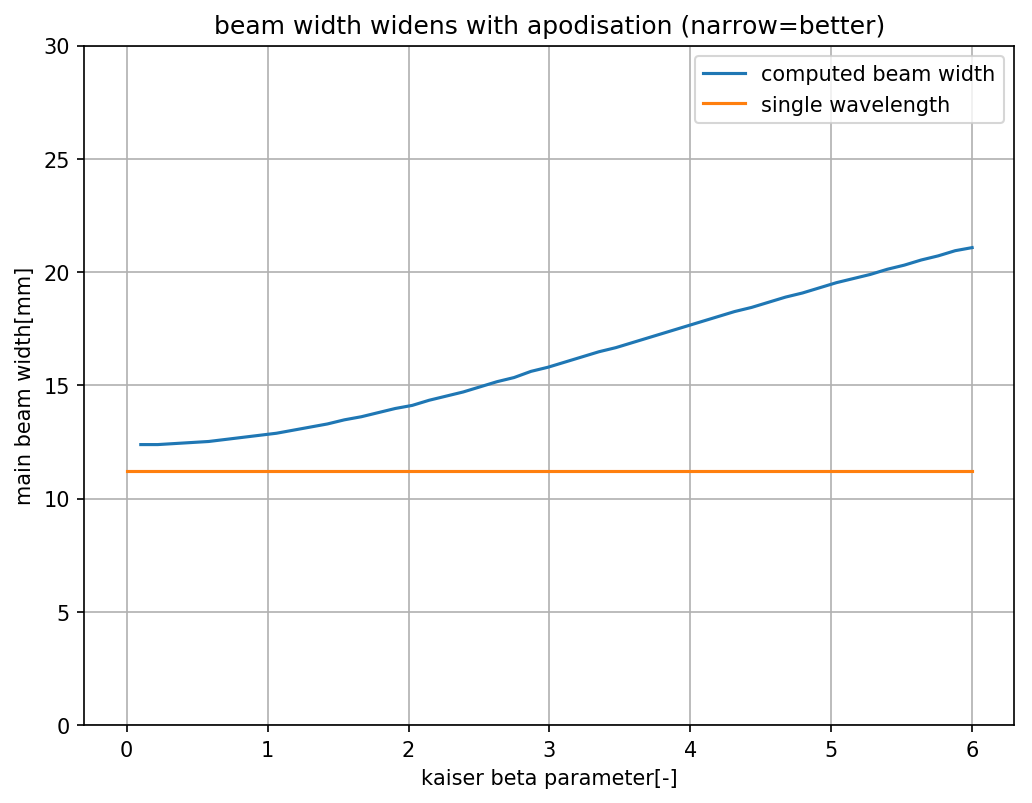

In [15]:
# plot the resolution measure
plt.figure(figsize=(8,6),dpi=150)
plt.plot(kaiser_betas,beam_width_linears*1e3)
plt.plot(np.array([0,6]),1e3*handybeam_world.medium_wavelength*np.array([1,1]))
plt.legend(['computed beam width','single wavelength'])
plt.xlabel('kaiser beta parameter[-]')
plt.ylabel('main beam width[mm]')
plt.title('beam width widens with apodisation (narrow=better)')
plt.ylim(0,30)

plt.grid(True)

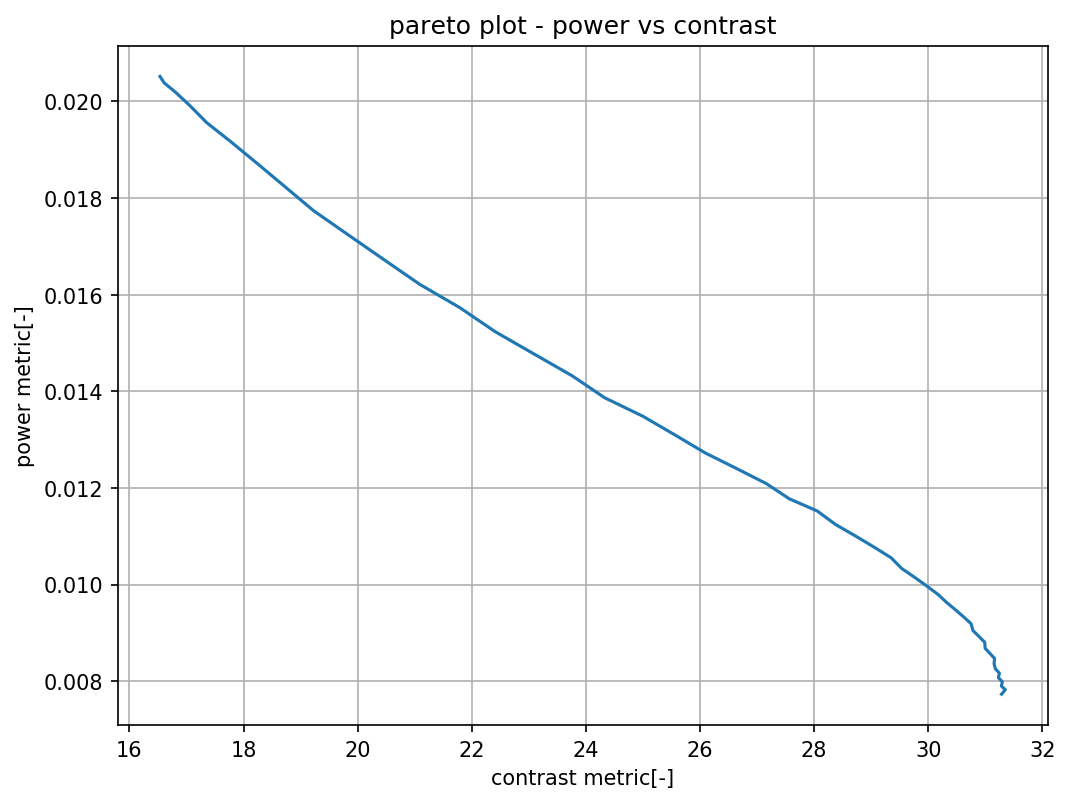

In [16]:
# pareto plot
plt.figure(figsize=(8,6),dpi=150)
plt.plot(contrast_mts_ratios,power_main_lobes)
plt.xlabel('contrast metric[-]')
plt.ylabel('power metric[-]')
plt.grid()
plt.title('pareto plot - power vs contrast')
plt.show()


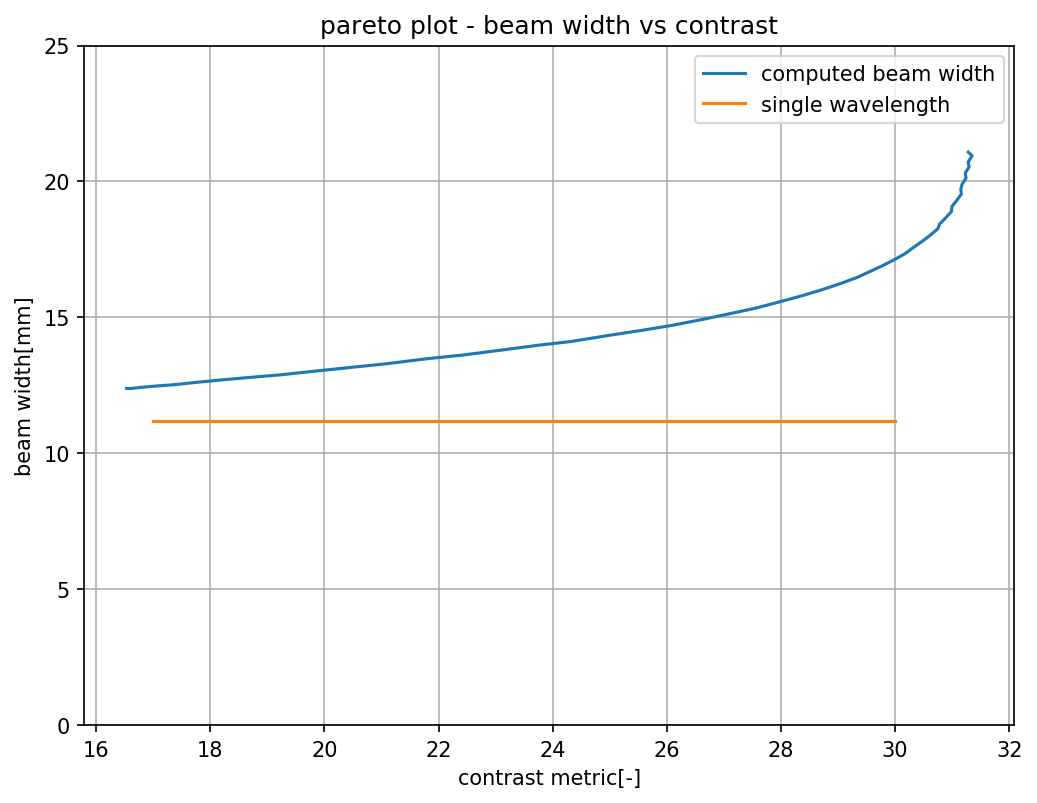

In [21]:
# pareto plot
plt.figure(figsize=(8,6),dpi=150)
plt.plot(contrast_mts_ratios,1e3*beam_width_linears)
plt.plot(np.array([17,30]),1e3*handybeam_world.medium_wavelength*np.array([1,1]))
plt.xlabel('contrast metric[-]')
plt.ylabel('beam width[mm]')
plt.ylim(0,25)
plt.legend(['computed beam width','single wavelength'])
plt.grid()
plt.title('pareto plot - beam width vs contrast')
plt.show()


In [22]:
# check performance - how many evaluations can You afford?
%timeit ab,hw,sc,sampler_angles,stats,world = array_using_kaiser(0.01)

98.9 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


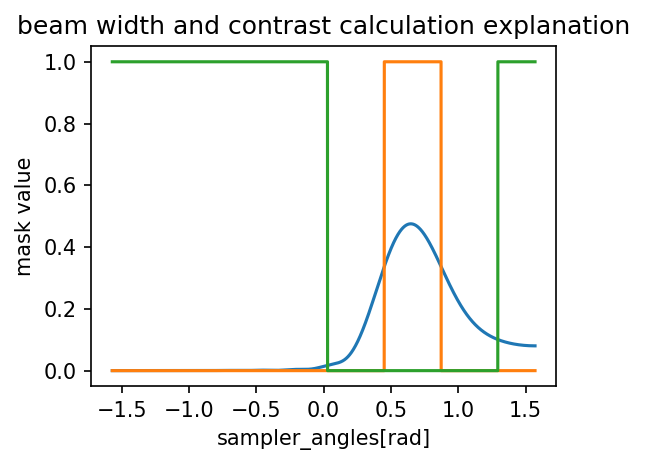

In [23]:
plt.figure(figsize=(4,3),dpi=150)
plt.plot(sampler_angles,np.abs(sc.pressure_field),sampler_angles,stats['db_mask_3db'],sampler_angles,~stats['mask_main_lobe'])
plt.xlabel('sampler_angles[rad]') 
plt.ylabel('mask value')
plt.title('beam width and contrast calculation explanation')
plt.show()
